In [118]:
import numpy as np
import os
from skimage import io
from skimage.filters.thresholding import threshold_li
from scipy import ndimage
from skimage import img_as_ubyte, img_as_uint
from skimage.morphology import opening, closing, binary_dilation
from skimage.morphology import disk
from skimage.segmentation import watershed

In [6]:
# Open image
root = '..\\..\\Experiments\\WKS026\\test'
well = 'D03'

well_folder = os.path.join(root, well)
img_path = os.path.join(well_folder, well + '_fused.tif')
img = io.imread(img_path)
print('Read the image')
io.imshow(img)

Read the image


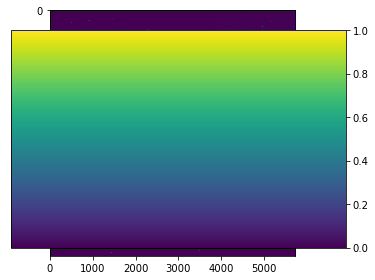

In [20]:
# Split chanels
atub = img[:,:,0] / np.max(img[:,:,0])
mapk2 = img[:,:,1] / np.max(img[:,:,1])
dapi = img[:,:,2] / np.max(img[:,:,2])

In [26]:
# Apply Li thresholding
th_atub = (atub > threshold_li(atub))
th_mapk2 = (mapk2 > threshold_li(mapk2))
th_dapi = (dapi > threshold_li(dapi))

In [62]:
# Open MAPKII and DAPI channel
op_mapk2 = opening(th_mapk2, selem=disk(2))
valid_dapi = th_dapi * op_mapk2

op_dapi = opening(valid_dapi, selem=disk(5))
op_cl_dapi = closing(op_dapi, selem=disk(5))

# Save results
fname = os.path.join(well_folder, 'mapk2_opening.tif')
io.imsave(fname, img_as_ubyte(op_mapk2))

fname = os.path.join(well_folder, 'dapi_opening_closing.tif')
io.imsave(fname, img_as_ubyte(op_cl_dapi))

In [65]:
# Label all nuclei with a seperate integer
lbl, n_obj = ndimage.label(op_cl_dapi)

# find center of mass of labels
com_list = ndimage.measurements.center_of_mass(op_cl_dapi, lbl, np.arange(1,n_obj+1))

In [128]:
# Make markers at the centers of mass of nuclei
N,M = op_cl_dapi.shape
markers = np.zeros((N,M))

i = 0
for x,y in com_list:
    i = i + 1
    markers[int(x), int(y)] = i

# Marker-conrolled watershed on MAPKII channel
mapk2_labels = watershed(op_mapk2, markers=markers, mask=op_mapk2, watershed_line=True)

# Save results
fname = os.path.join(well_folder, 'mapk2_label.tif')
io.imsave(fname, img_as_uint(mapk2_labels))

fname = os.path.join(well_folder, 'markers.tif')
io.imsave(fname, img_as_ubyte(markers))

In [109]:
def grow(growing_seed, mask, selem_radius=5):
    
    new_growing_seed = binary_dilation(growing_seed, selem = disk(selem_radius))
    new_growing_seed = np.logical_and(new_growing_seed, mask)
    
    return new_growing_seed

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


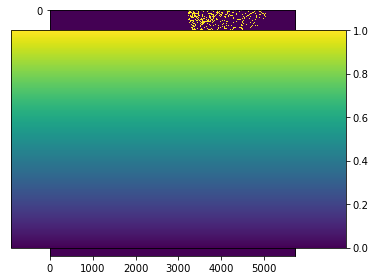

In [129]:
growing_seed = np.zeros((N,M))
new_growing_seed = np.zeros((N,M))

i = 1
x,y = com_list[i-1]
new_growing_seed[int(x), int(y)] = 1

other_mapk2_labels = mapk2_labels - i * (mapk2_labels == i)

count = 0
while not np.array_equal(growing_seed, new_growing_seed):

    print(count)
    growing_seed = new_growing_seed
    new_growing_seed = grow(growing_seed, th_atub, selem_radius=10)
    
    if np.sum(new_growing_seed * other_mapk2_labels) > 0:
        break
    
    count = count + 1
    if count == 100:
        break

io.imshow(new_growing_seed)

In [130]:
fname = os.path.join(well_folder, 'new_growing_seed.tif')
io.imsave(fname, img_as_ubyte(new_growing_seed))

In [106]:
count

0

In [127]:
count

0